# Tutorial 3: resolution of wave equation with hard constraint PINNs.

### The problem solution 

In this tutorial we present how to solve the wave equation using hard constraint PINNs. For doing so we will build a costum torch model and pass it to the `PINN` solver.

The problem is written in the following form:

\begin{equation}
\begin{cases}
\Delta u(x,y,t) = \frac{\partial^2}{\partial t^2} u(x,y,t) \quad \text{in } D, \\\\
u(x, y, t=0) = \sin(\pi x)\sin(\pi y), \\\\
u(x, y, t) = 0 \quad \text{on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}

where $D$ is a square domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square, and the velocity in the standard wave equation is fixed to one.

First of all, some useful imports.

In [1]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import laplacian, grad
from pina.geometry import CartesianDomain
from pina.solvers import PINN
from pina.trainer import Trainer
from pina.equation import Equation
from pina.equation.equation_factory import FixedValue
from pina import Condition, Plotter

Now, the wave problem is written in PINA code as a class, inheriting from `SpatialProblem` and `TimeDependentProblem` since we deal with spatial, and time dependent variables. The equations are written as `conditions` that should be satisfied in the corresponding domains. `truth_solution` is the exact solution which will be compared with the predicted one.

In [2]:
class Wave(TimeDependentProblem, SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1], 'y': [0, 1]})
    temporal_domain = CartesianDomain({'t': [0, 1]})

    def wave_equation(input_, output_):
        u_t = grad(output_, input_, components=['u'], d=['t'])
        u_tt = grad(u_t, input_, components=['dudt'], d=['t'])
        nabla_u = laplacian(output_, input_, components=['u'], d=['x', 'y'])
        return nabla_u - u_tt

    def initial_condition(input_, output_):
        u_expected = (torch.sin(torch.pi*input_.extract(['x'])) *
                      torch.sin(torch.pi*input_.extract(['y'])))
        return output_.extract(['u']) - u_expected

    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': [0, 1], 'y':  1, 't': [0, 1]}), equation=FixedValue(0.)),
        'gamma2': Condition(location=CartesianDomain({'x': [0, 1], 'y': 0, 't': [0, 1]}), equation=FixedValue(0.)),
        'gamma3': Condition(location=CartesianDomain({'x':  1, 'y': [0, 1], 't': [0, 1]}), equation=FixedValue(0.)),
        'gamma4': Condition(location=CartesianDomain({'x': 0, 'y': [0, 1], 't': [0, 1]}), equation=FixedValue(0.)),
        't0': Condition(location=CartesianDomain({'x': [0, 1], 'y': [0, 1], 't': 0}), equation=Equation(initial_condition)),
        'D': Condition(location=CartesianDomain({'x': [0, 1], 'y': [0, 1], 't': [0, 1]}), equation=Equation(wave_equation)),
    }

    def wave_sol(self, pts):
        return (torch.sin(torch.pi*pts.extract(['x'])) *
                torch.sin(torch.pi*pts.extract(['y'])) *
                torch.cos(torch.sqrt(torch.tensor(2.))*torch.pi*pts.extract(['t'])))

    truth_solution = wave_sol

problem = Wave()

After the problem, a **torch** model is needed to solve the PINN. Usually many models are already implemented in `PINA`, but the user has the possibility to build his/her own model in `pyTorch`. The hard constraint we impose are on the boundary of the spatial domain. Specificly our solution is written as:

$$ u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t), $$

where $NN$ is the neural net output. This neural network takes as input the coordinates (in this case $x$, $y$ and $t$) and provides the unkwown field of the Wave problem. By construction it is zero on the boundaries. The residual of the equations are evaluated at several sampling points (which the user can manipulate using the method `discretise_domain`) and the loss minimized by the neural network is the sum of the residuals.

In [3]:
class HardMLP(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(torch.nn.Linear(input_dim, 20),
                                          torch.nn.Tanh(),
                                          torch.nn.Linear(20, 20),
                                          torch.nn.Tanh(),
                                          torch.nn.Linear(20, output_dim))
        
    # here in the foward we implement the hard constraints
    def forward(self, x):
        hard = x.extract(['x'])*(1-x.extract(['x']))*x.extract(['y'])*(1-x.extract(['y']))
        return hard*self.layers(x)

In this tutorial, the neural network is trained for 3000 epochs with a learning rate of 0.001 (default in `PINN`). Training takes approximately 1 minute.

In [7]:
pinn = PINN(problem, HardMLP(len(problem.input_variables), len(problem.output_variables)))
problem.discretise_domain(1000, 'random', locations=['D','t0', 'gamma1', 'gamma2', 'gamma3', 'gamma4'])
trainer = Trainer(pinn, max_epochs=3000)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 521   
----------------------------------------
521       Trainable params
0         Non-trainable params
521       Total params
0.002     Total estimated model params size (MB)


Epoch 2999: : 1it [00:00, 79.33it/s, v_num=5, mean_loss=0.00119, D_loss=0.00542, t0_loss=0.0017, gamma1_loss=0.000, gamma2_loss=0.000, gamma3_loss=0.000, gamma4_loss=0.000]  

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: : 1it [00:00, 68.62it/s, v_num=5, mean_loss=0.00119, D_loss=0.00542, t0_loss=0.0017, gamma1_loss=0.000, gamma2_loss=0.000, gamma3_loss=0.000, gamma4_loss=0.000]


Notice that the loss on the boundaries of the spatial domain is exactly zero, as expected! After the training is completed one can now plot some results using the `Plotter` class of **PINA**.

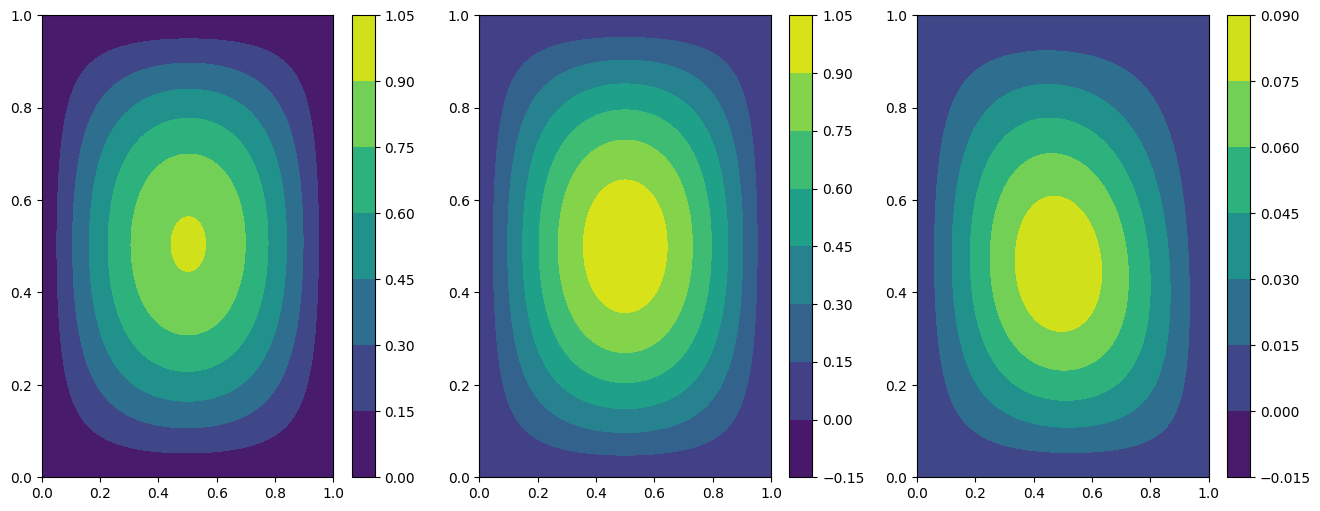

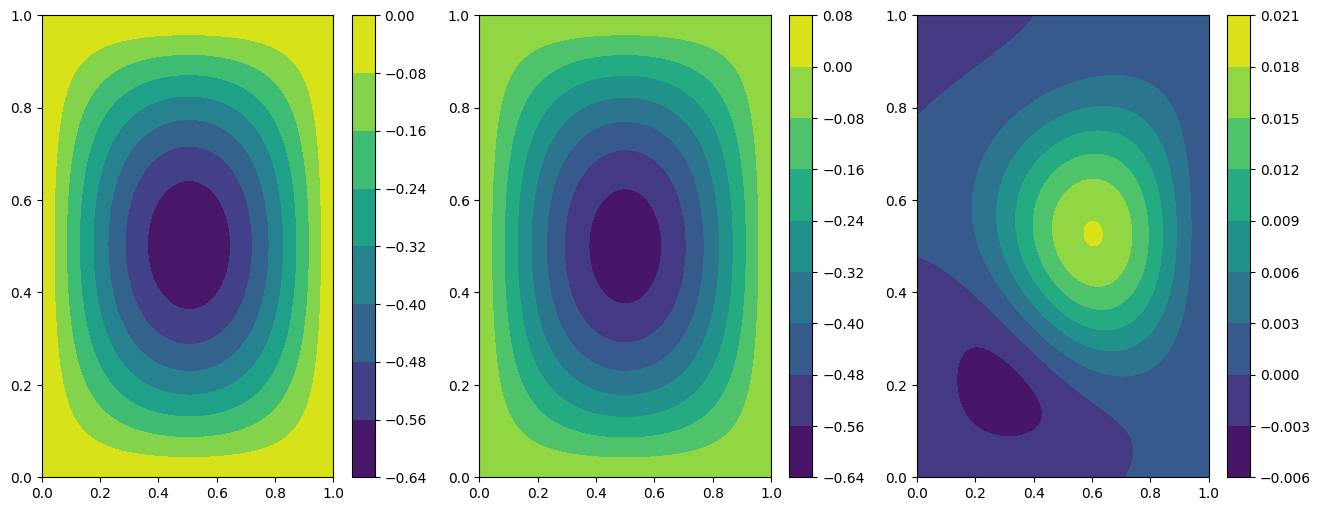

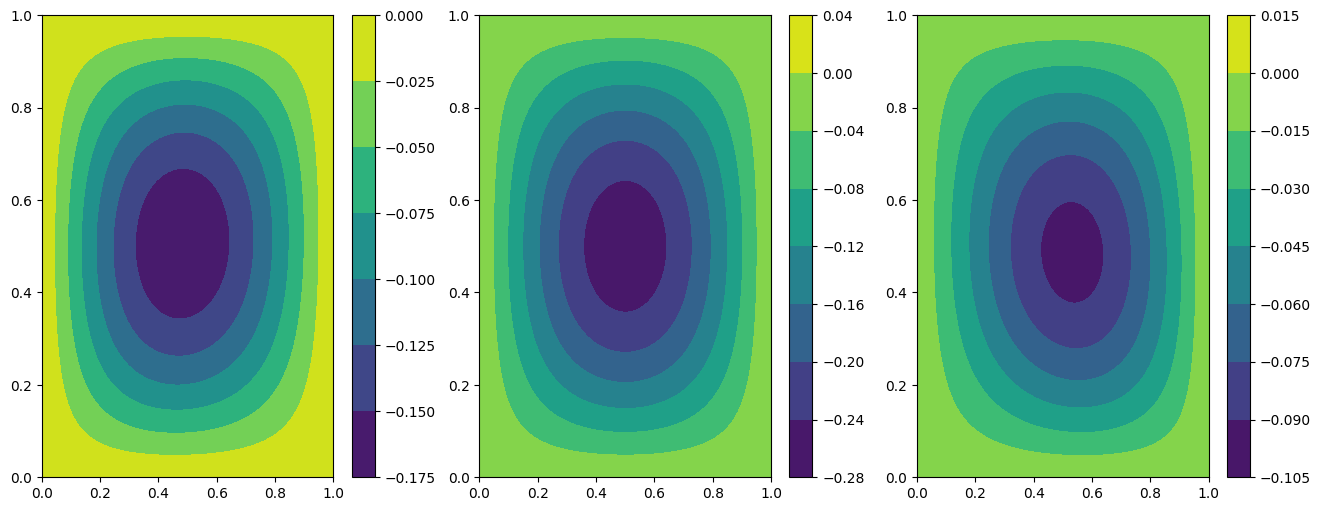

In [11]:
plotter = Plotter()

# plotting at fixed time t = 0.0
plotter.plot(trainer, fixed_variables={'t': 0.0})

# plotting at fixed time t = 0.5
plotter.plot(trainer, fixed_variables={'t': 0.5})

# plotting at fixed time t = 1.
plotter.plot(trainer, fixed_variables={'t': 1.0})
